---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-text-mining/resources/d9pwm) course resource._

---

*Note: Some of the cells in this notebook are computationally expensive. To reduce runtime, this notebook is using a subset of the data.*

# Case Study: Sentiment Analysis

### Data Prep

In [1]:
bbtheory_chars={} 
Penny=''
Raj=''
Sheldon=''
Leonard=''
Howard=''

with open("big_bang_transcripts/season_all/merged.csv", "r+") as fp:
    for cnt, line in enumerate(fp):
        if line.startswith('Raj:'):
            Raj=Raj+' '+(line[5:])
        elif line.startswith('Penny:'):
            Penny=Penny+' '+(line[7:])
        elif line.startswith('Sheldon:'):
            Sheldon=Sheldon+' '+(line[9:])
        elif line.startswith('Leonard:'):
            Leonard=Leonard+' '+(line[9:])
        if line.startswith('Howard:'):
            Howard=Howard+' '+(line[8:])
       

bbtheory_chars['Raj']=Raj
bbtheory_chars['Penny']=Penny
bbtheory_chars['Sheldon']=Sheldon
bbtheory_chars['Leonard']=Leonard
bbtheory_chars['Howard']=Howard


In [3]:
import pandas as pd
df6 = pd.DataFrame([x for x in bbtheory_chars['Raj'].split('\n')])

df5 = pd.DataFrame([x for x in bbtheory_chars['Penny'].split('\n')])

df4 = pd.DataFrame([x for x in bbtheory_chars['Sheldon'].split('\n')])
df3 = pd.DataFrame([x for x in bbtheory_chars['Leonard'].split('\n')])

df2 = pd.DataFrame([x for x in bbtheory_chars['Howard'].split('\n')])


In [4]:
df2.head()

,0
0,Wait till you see this.
1,It’s a Stephen Hawking lecture from MIT in 1974.
2,It’s before he became a creepy computer voice:.
3,"Yeah, right, your grandmother back in town?"
4,"Hang on, there really is a lady here?"


In [5]:
df6.shape

(1700, 1)

In [6]:
listOfScores1 = ['Raj'] *df6.shape[0]
listOfScores2 = ['Penny'] *df5.shape[0]
listOfScores3 = ['Sheldon'] *df4.shape[0]
listOfScores4 = ['Leonard'] *df3.shape[0]
listOfScores5 = ['Howard'] *df2.shape[0]


In [7]:
df6['Score'] = listOfScores1
df5['Score'] = listOfScores2 
df4['Score'] = listOfScores3
df3['Score'] = listOfScores4
df2['Score'] = listOfScores5


In [8]:
df2=df2.rename(columns={0: 'dialogue'})
df3=df3.rename(columns={0: 'dialogue'})
df4=df4.rename(columns={0: 'dialogue'})
df5=df5.rename(columns={0: 'dialogue'})
df6=df6.rename(columns={0: 'dialogue'})

In [9]:
df = pd.concat([df2,df3,df4,df5,df6])
df.tail()

,dialogue,Score
1695,"Nothing, I’m fine.",Raj
1696,No. (Bursts into tears),Raj
1697,I’m so lonely.,Raj
1698,I didn’t get a lot of that because of your ac...,Raj
1699,,Raj


In [10]:
from io import StringIO
col = ['Score', 'dialogue']
df = df[col]
df = df[pd.notnull(df['dialogue'])]
df.columns = ['Score', 'dialogue']
df['category_id'] = df['Score'].factorize()[0]
category_id_df = df[['Score', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Score']].values)
df.tail()


,Score,dialogue,category_id
1695,Raj,"Nothing, I’m fine.",4
1696,Raj,No. (Bursts into tears),4
1697,Raj,I’m so lonely.,4
1698,Raj,I didn’t get a lot of that because of your ac...,4
1699,Raj,,4


In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


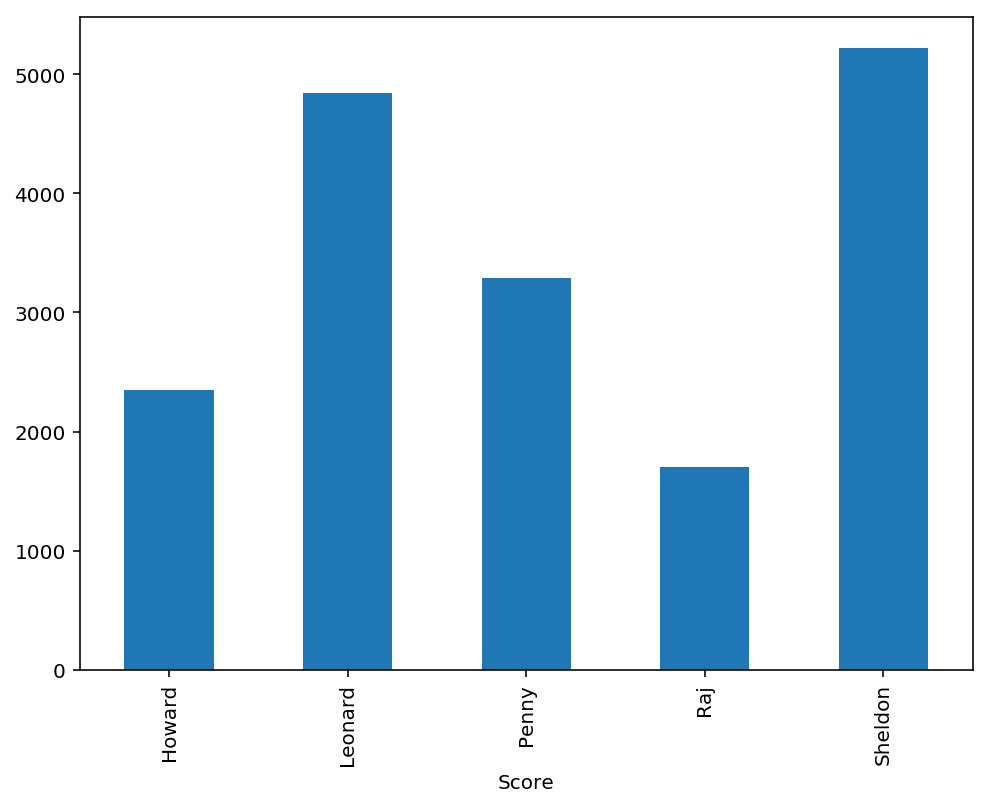

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Score').dialogue.count().plot.bar(ylim=0)
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.dialogue).toarray()
labels = df.Score
features.shape

(17409, 3558)

In [14]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Score, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Score))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Howard':
  . Most correlated unigrams:
. going
. zone
  . Most correlated bigrams:
. going talk
. going let
# 'Leonard':
  . Most correlated unigrams:
. going
. zone
  . Most correlated bigrams:
. going talk
. going let
# 'Penny':
  . Most correlated unigrams:
. going
. zone
  . Most correlated bigrams:
. going talk
. going let
# 'Raj':
  . Most correlated unigrams:
. going
. zone
  . Most correlated bigrams:
. going talk
. going let
# 'Sheldon':
  . Most correlated unigrams:
. going
. zone
  . Most correlated bigrams:
. going talk
. going let


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['dialogue'], df['Score'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
print(clf.predict(count_vect.transform(["Yeah, well you promised Barry, you d marry him. (Rachel glares at her, and she retreats to safety between Richards legs)"])))

['Ross']


In [18]:
print(clf.predict(count_vect.transform(["And I will be using his dead body as a shield"])))

['Phoebe']


In [19]:
!pip3 install seaborn


You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

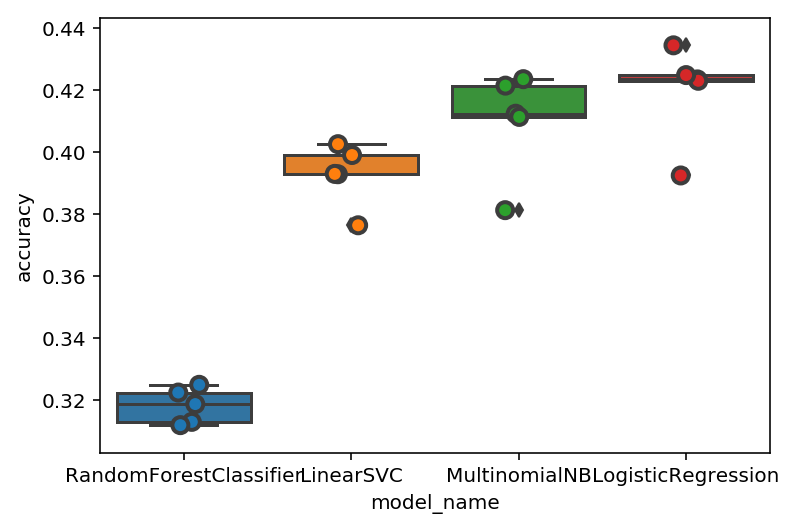

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [17]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.392787
LogisticRegression        0.419671
MultinomialNB             0.410020
RandomForestClassifier    0.318170
Name: accuracy, dtype: float64

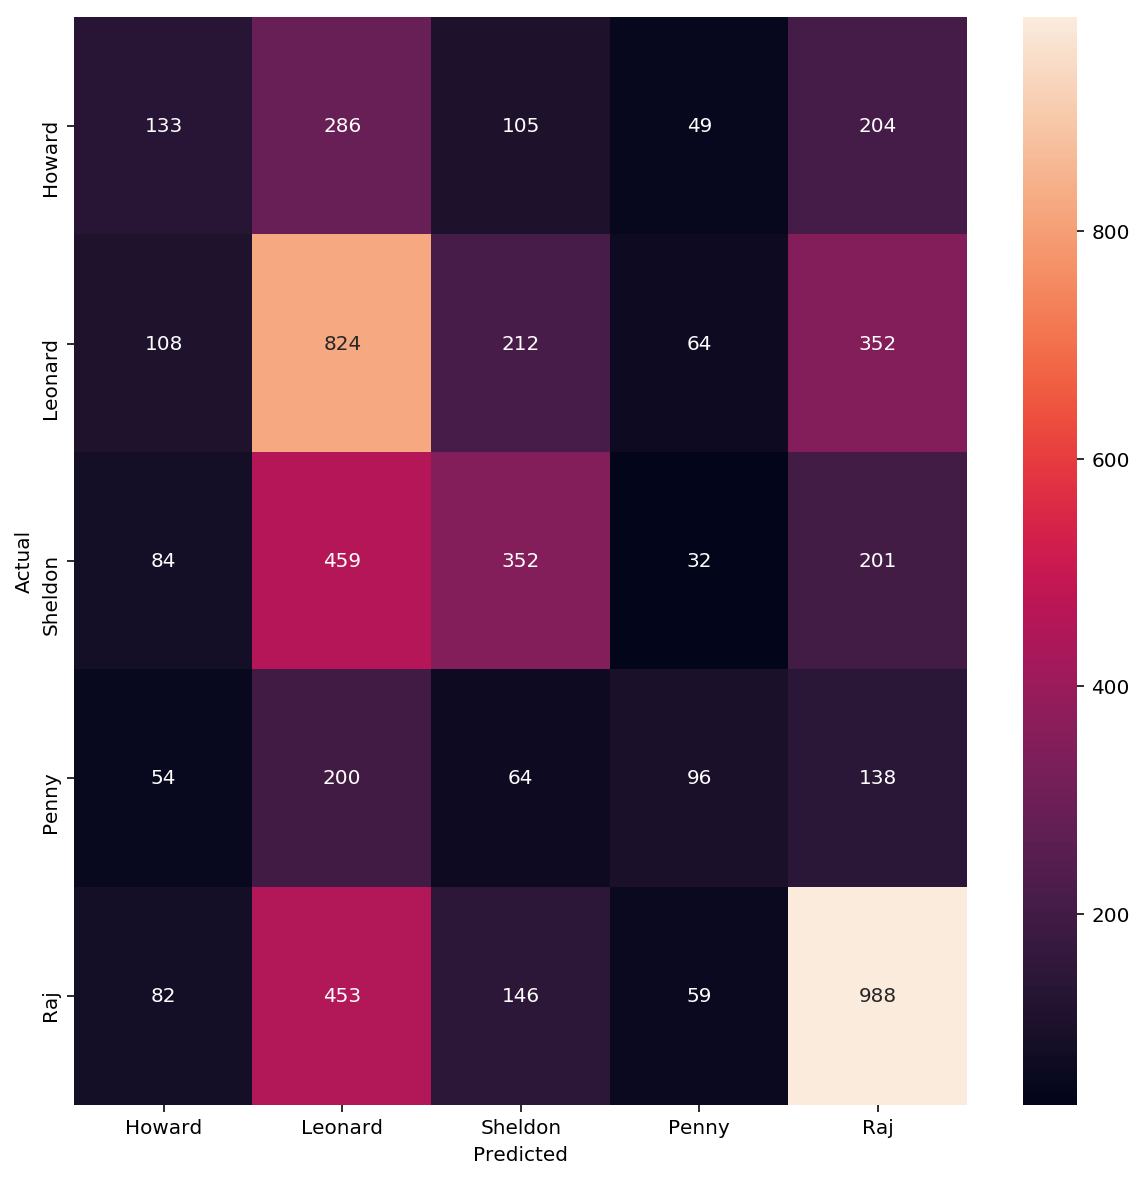

In [18]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Score.values, yticklabels=category_id_df.Score.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [19]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Score', 'dialogue']])
      print('')

'Leonard' predicted as 'Howard' : 108 examples.


,Score,dialogue



'Sheldon' predicted as 'Howard' : 84 examples.


,Score,dialogue



'Penny' predicted as 'Howard' : 54 examples.


,Score,dialogue



'Raj' predicted as 'Howard' : 82 examples.


,Score,dialogue



'Howard' predicted as 'Leonard' : 286 examples.


,Score,dialogue



'Sheldon' predicted as 'Leonard' : 459 examples.


,Score,dialogue



'Penny' predicted as 'Leonard' : 200 examples.


,Score,dialogue



'Raj' predicted as 'Leonard' : 453 examples.


,Score,dialogue



'Howard' predicted as 'Sheldon' : 105 examples.


,Score,dialogue



'Leonard' predicted as 'Sheldon' : 212 examples.


,Score,dialogue



'Penny' predicted as 'Sheldon' : 64 examples.


,Score,dialogue



'Raj' predicted as 'Sheldon' : 146 examples.


,Score,dialogue



'Howard' predicted as 'Penny' : 49 examples.


,Score,dialogue



'Leonard' predicted as 'Penny' : 64 examples.


,Score,dialogue



'Sheldon' predicted as 'Penny' : 32 examples.


,Score,dialogue



'Raj' predicted as 'Penny' : 59 examples.


,Score,dialogue



'Howard' predicted as 'Raj' : 204 examples.


,Score,dialogue



'Leonard' predicted as 'Raj' : 352 examples.


,Score,dialogue



'Sheldon' predicted as 'Raj' : 201 examples.


,Score,dialogue



'Penny' predicted as 'Raj' : 138 examples.


,Score,dialogue


In [20]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'Howard':
  . Top unigrams:
       . katee
       . sensor
  . Top bigrams:
       . howard wolowitz
       . girl like
# 'Leonard':
  . Top unigrams:
       . neighbours
       . conference
  . Top bigrams:
       . raj sister
       . try way
# 'Penny':
  . Top unigrams:
       . dude
       . papa
  . Top bigrams:
       . let ring
       . feel bad
# 'Raj':
  . Top unigrams:
       . stock
       . remarkable
  . Top bigrams:
       . magic trick
       . let know
# 'Sheldon':
  . Top unigrams:
       . manager
       . sweetie
  . Top bigrams:
       . knock sheldon
       . got work


In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Score'].unique()))

              precision    recall  f1-score   support

      Howard       0.29      0.17      0.21       777
     Leonard       0.37      0.53      0.44      1560
     Sheldon       0.40      0.31      0.35      1128
       Penny       0.32      0.17      0.23       552
         Raj       0.52      0.57      0.55      1728

    accuracy                           0.42      5745
   macro avg       0.38      0.35      0.35      5745
weighted avg       0.41      0.42      0.40      5745

